### Post-processing analysis for occlusion method

In [1]:
# 3rd party
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
import matplotlib.pyplot as plt

# local
from archived_experiments.explainability.post_processing.utils_postprocessing import post_process_flags, top_n, threshold

# Reading results for train, val and test sets

In [2]:
# Read data from occlusion test
occlusion_root_dir = Path('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/explainability/occlusion/run_occlusion_zero_05-11-2023_1650')

train = pd.read_csv(occlusion_root_dir / 'train.csv')
val = pd.read_csv(occlusion_root_dir / 'val.csv')
test = pd.read_csv(occlusion_root_dir / 'test.csv')

get_max = True  # get max top-n
branch_idxs_to_keep = [1, 2, 3, 4, 6, 7]  # do not keep global flux and stellar
robo_cols = ['Global Flux Flag', 'Local Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'Stellar Flag', 'DV Flag', 'No Flag']
score_cols = ['global flux', 'local_flux', 'global_and_local_centroid', 'odd_even', 'secondary', 'stellar', 'DV']

# Load Robovetter flag table

In [3]:
# Load Robovetter Minor Flags
robo_flags = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/interns/kaylie_explainability/kdd/robovetter_flags_all_DR25.csv')

In [4]:
robo_flags.head()
# adding no flag column for TCEs with no FP flags set to one
robo_flags['No Flag'] = 0
# robo_flags.loc[(robo_flags[robo_cols[:-1]] == 0).all(axis=1), 'No Flag'] = 1

tce_tbl = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/data/ephemeris_tables/kepler/q1-q17_dr25/11-17-2021_1243/q1_q17_dr25_tce_3-6-2023_1734.csv')
robo_flags['uid'] = robo_flags[['target_id', 'tce_plnt_num']].apply(lambda x: f'{x[0]}-{x[1]}', axis=1)
robo_flags['uid'].value_counts()
robo_flags = robo_flags.merge(tce_tbl[['uid', 'label']], on=['uid'], how='left', validate='one_to_one')
robo_flags.loc[robo_flags['label'] == 'PC', 'No Flag'] = 1

In [5]:
# Merge Robovetter Flags with test set occlusion results
test_csv = pd.merge(test, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

# # exclude non-KOIs
# tce_tbl = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/data/ephemeris_tables/kepler/q1-q17_dr25/11-17-2021_1243/q1_q17_dr25_tce_3-6-2023_1734.csv')
# test_csv = pd.merge(test_csv, tce_tbl[['target_id', 'tce_plnt_num', 'kepoi_name']], on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')
# test_csv = test_csv.loc[~test_csv['kepoi_name'].isna()]

In [6]:
test_csv['label_y'].value_counts(), test_csv['No Flag'].value_counts()

(NTP    2453
 AFP     334
 PC      276
 Name: label_y, dtype: int64,
 0    2787
 1     276
 Name: No Flag, dtype: int64)

In [65]:
all_dataset_tbl = pd.merge(pd.concat([train, val, test], axis=0).reset_index(), robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')
all_dataset_tbl.head()

,index,target_id,tce_plnt_num,tce_period,tce_duration,original_label,label_x,global flux,local_flux,global_and_local_centroid,...,Global Flux Flag,Local Flux Flag,Centroid Flag,Odd Even Flag,Secondary Flag,Stellar Flag,DV Flag,No Flag,uid,label_y
0,0,9651602,2,674.192017,0.717917,NTP,0,-8.294677e-06,1.754462e-05,6.192480e-05,...,0,1,0,0,0,0,0,0,9651602-2,NTP
1,1,7199002,1,0.566713,0.183542,NTP,0,2.333365e-10,1.046336e-17,5.067187e-20,...,0,1,0,0,0,0,0,0,7199002-1,NTP
2,2,7901074,1,368.937012,0.924583,NTP,0,-1.505092e-15,6.556168e-10,5.338736e-14,...,0,1,0,0,0,0,1,0,7901074-1,NTP
3,3,8561063,1,1.213770,0.027863,PC,1,-3.006733e-01,-8.633822e-02,1.276032e-01,...,0,0,0,0,0,0,0,1,8561063-1,PC
4,4,10398088,3,5.611410,0.031212,NTP,0,3.562813e-05,2.564761e-08,2.297681e-10,...,0,1,0,0,0,0,0,0,10398088-3,NTP


In [82]:
# all_dataset_tbl['label_y'].value_counts()
# (all_dataset_tbl['label_y'].isin(['AFP', 'NTP']).sum())
all_dataset_tbl[np.array(robo_cols)[branch_idxs_to_keep]].sum(axis=0)

Local Flux Flag    21704
Centroid Flag       2668
Odd Even Flag        608
Secondary Flag      2666
DV Flag             3141
No Flag             2643
dtype: int64

In [96]:
# unique odd and even (no other flags on)
flag_cols = ['Local Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']

for flag in flag_cols:
    cnt_unique_examples_flag = ((all_dataset_tbl[flag] == 1) & ((all_dataset_tbl[[col for col in robo_cols if col != flag]] == 0).all(axis=1))).sum()
    if flag == 'Local Flux Flag':
        flag_name = 'Flux'
    else:
        flag_name = flag
    print(f'Unique number of examples for {flag_name}: {cnt_unique_examples_flag}')


Unique number of examples for Flux: 18184
Unique number of examples for Centroid Flag: 478
Unique number of examples for Odd Even Flag: 105
Unique number of examples for Secondary Flag: 1265
Unique number of examples for DV Flag: 410


In [7]:
# get columns with scores for each occlusion grouping
occlusion_array = np.array(test_csv[score_cols])
# get flags for each branch
robo_array = np.array(test_csv[robo_cols])

In [8]:
_, occlusion = post_process_flags(robo_array, occlusion_array, get_max=True, branch_idxs_to_keep=branch_idxs_to_keep[:-1])
# set to one when all other flags have non-positive explanation scores
# occlusion_array[(occlusion_array <= 0)] = 0
robo = robo_array[:, branch_idxs_to_keep]
robo = np.array(robo[:, :-1])
robo_noflag = np.array(robo_array[:, -1])

In [9]:
# get number of cases for each flag
np.sum(robo, axis=0), len(robo), np.sum(robo, axis=0) / len(robo) * 100, np.mean(np.sum(robo, axis=0) / len(robo) * 100)

(array([2133,  263,   60,  257,  321]),
 3063,
 array([69.63761019,  8.58635325,  1.95886386,  8.39046686, 10.47992165]),
 19.810643160300362)

In [10]:
((occlusion_array[:, 0] >= 0) & (robo[:, 0] == 0)).sum()

283

In [11]:
2133 / (2133+930)

0.6963761018609207

# Compute top-n metrics across FP flags

In [12]:
top_n_arr = np.arange(1,6)  # top-n values
# metrics to be computed for each top-n
metrics_dict = {
    'precision_micro': {'average': 'micro', 'zero_division': 1},
    'precision_macro': {'average': 'macro', 'zero_division': 1},
    'precision_weighted': {'average': 'weighted', 'zero_division': 1},

    'recall_micro': {'average': 'micro', 'zero_division': 1},
    'recall_macro': {'average': 'macro', 'zero_division': 1},
    'recall_weighted': {'average': 'weighted', 'zero_division': 1},

    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},

    'jaccard_micro': {'average': 'micro', 'zero_division': 1},
    'jaccard_macro': {'average': 'macro', 'zero_division': 1},
    'jaccard_weighted': {'average': 'weighted', 'zero_division': 1},

}
metrics_res = {'top_n': top_n_arr}
metrics_res.update({metric_i: np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_dict})

# # add no_flag column; set to one when all other flags have non-positive explanation scores
# occlusion_array[(occlusion_array <= 0)] = 0
# noflag_explanation = np.zeros((len(occlusion_array), 1), dtype='float')
# noflag_explanation[(occlusion_array == 0).all(axis=1)] = 1
# occlusion_array = np.concatenate([occlusion_array, noflag_explanation], axis=1)

for n_i, n in enumerate(top_n_arr):

    branch_explanations_topn = top_n(occlusion, n, get_max)

    for metric_i, metrics_params in metrics_dict.items():

        if 'precision' in metric_i:
            metrics_res[metric_i][n_i] = precision_score(robo, branch_explanations_topn, **metrics_params)
        elif 'recall' in metric_i:
            metrics_res[metric_i][n_i] = recall_score(robo, branch_explanations_topn, **metrics_params)
        elif 'hamming' in metric_i:
            metrics_res[metric_i][n_i] = 1 - hamming_loss(robo, branch_explanations_topn, **metrics_params)
        elif 'jaccard' in metric_i:
            metrics_res[metric_i][n_i] = jaccard_score(robo, branch_explanations_topn, **metrics_params)
        elif 'exact_match_ratio' in metric_i:
            metrics_res[metric_i][n_i] = accuracy_score(robo, branch_explanations_topn, **metrics_params)

metrics_res_df = pd.DataFrame(metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(occlusion_root_dir / f'metrics_top_n_{top_n_arr[0]}-{top_n_arr[-1]}.csv', index=False)

# Compute metrics across FP flags for a set of threshold values

In [13]:
thr_arr = np.linspace(-1, 1, 21, endpoint=True)

# metrics to be computed for the given threshold
metrics_dict = {
    'precision_micro': {'average': 'micro', 'zero_division': 1},
    'precision_macro': {'average': 'macro', 'zero_division': 1},
    'precision_weighted': {'average': 'weighted', 'zero_division': 1},
    'precision_samples': {'average': 'samples', 'zero_division': 1},

    'recall_micro': {'average': 'micro', 'zero_division': 1},
    'recall_macro': {'average': 'macro', 'zero_division': 1},
    'recall_weighted': {'average': 'weighted', 'zero_division': 1},
    'recall_samples': {'average': 'samples', 'zero_division': 1},

    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},

    'jaccard_micro': {'average': 'micro', 'zero_division': 1},
    'jaccard_macro': {'average': 'macro', 'zero_division': 1},
    'jaccard_weighted': {'average': 'weighted', 'zero_division': 1},
    'jaccard_samples': {'average': 'samples', 'zero_division': 1},
}

metrics_res = {'thr': thr_arr}
metrics_res.update({metric_i: np.nan * np.ones(len(thr_arr)) for metric_i in metrics_dict})

for thr_i, thr in enumerate(thr_arr):

    branch_explanations_thr = threshold(occlusion, thr)
    # # add no_flag column; set to one when all other flags have non-positive explanation scores
    # branch_explanations_thr[(branch_explanations_thr[:, :-1] == 0).all(axis=1), -1] = 1

    for metric_i, metrics_params in metrics_dict.items():

        if 'precision' in metric_i:
            metrics_res[metric_i][thr_i] = precision_score(robo, branch_explanations_thr, **metrics_params)
        elif 'recall' in metric_i:
            metrics_res[metric_i][thr_i] = recall_score(robo, branch_explanations_thr, **metrics_params)
        elif 'hamming' in metric_i:
            metrics_res[metric_i][thr_i] = 1 - hamming_loss(robo, branch_explanations_thr, **metrics_params)
        elif 'jaccard' in metric_i:
            metrics_res[metric_i][thr_i] = jaccard_score(robo, branch_explanations_thr, **metrics_params)
        elif 'exact_match_ratio' in metric_i:
            metrics_res[metric_i][thr_i] = accuracy_score(robo, branch_explanations_thr, **metrics_params)

metrics_res_df = pd.DataFrame(metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(occlusion_root_dir / f'metrics_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

# Compute metrics for PC for a set of threshold values

In [14]:
thr_arr = np.linspace(-1, 1, 21, endpoint=True)

# metrics to be computed for the given threshold
metrics_dict = {
    'precision': {'zero_division': 1},
    'recall': {'zero_division': 1},
    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},
    'jaccard': {'zero_division': 1},
}

metrics_res = {'thr': thr_arr}
metrics_res.update({metric_i: np.nan * np.ones(len(thr_arr)) for metric_i in metrics_dict})

for thr_i, thr in enumerate(thr_arr):

    # add no_flag column; set to one when all other flags have non-positive explanation scores
    idxs_allfps_inactive = (occlusion_array <= thr).all(axis=1)
    noflag_explanation = np.zeros((len(occlusion_array), 1), dtype='float')
    noflag_explanation[idxs_allfps_inactive] = 1

    branch_explanations_thr = threshold(noflag_explanation, thr)

    for metric_i, metrics_params in metrics_dict.items():

        if 'precision' in metric_i:
            metrics_res[metric_i][thr_i] = precision_score(robo_noflag, branch_explanations_thr, **metrics_params)
        elif 'recall' in metric_i:
            metrics_res[metric_i][thr_i] = recall_score(robo_noflag, branch_explanations_thr, **metrics_params)
        elif 'hamming' in metric_i:
            metrics_res[metric_i][thr_i] = 1 - hamming_loss(robo_noflag, branch_explanations_thr, **metrics_params)
        elif 'jaccard' in metric_i:
            metrics_res[metric_i][thr_i] = jaccard_score(robo_noflag, branch_explanations_thr, **metrics_params)
        elif 'exact_match_ratio' in metric_i:
            metrics_res[metric_i][thr_i] = accuracy_score(robo_noflag, branch_explanations_thr, **metrics_params)

metrics_res_df = pd.DataFrame(metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(occlusion_root_dir / f'metrics_pc_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

### Compute top-n precision and recall values for each feature group

In [15]:
top_n_arr = np.arange(1, 6)  # top-n values
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']
# metrics to be computed for each top-n
metrics_res = {'top_n': top_n_arr}
for flag in flags:
    metrics_res[f'precision_{flag}'] = np.zeros_like(top_n_arr, dtype='float')
    metrics_res[f'recall_{flag}'] = np.zeros_like(top_n_arr, dtype='float')

for n_i, n in enumerate(top_n_arr):

    branch_explanations_topn = top_n(occlusion, n, get_max)

    for flag_i in range(len(flags)):
        metrics_res[f'precision_{flags[flag_i]}'][n_i] = precision_score(robo[:, flag_i], branch_explanations_topn[:, flag_i], zero_division=1)
        metrics_res[f'recall_{flags[flag_i]}'][n_i] = recall_score(robo[:, flag_i], branch_explanations_topn[:, flag_i], zero_division=1)

metrics_res_df = pd.DataFrame(metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(occlusion_root_dir / f'precision_recall_per_flag_top_n_{top_n_arr[0]}-{top_n_arr[-1]}.csv', index=False)

In [16]:
# precision and recall for a set of threshold for each feature group
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']
thr_arr = np.linspace(-1, 1, 21, endpoint=True)
# metrics to be computed for each threshold value
metrics_res = {'thr': thr_arr}
for flag in flags:
    metrics_res[f'precision_{flag}'] = np.zeros_like(thr_arr, dtype='float')
    metrics_res[f'recall_{flag}'] = np.zeros_like(thr_arr, dtype='float')

for thr_i, thr in enumerate(thr_arr):

    branch_explanations_thr = threshold(occlusion, thr)

    for flag_i in range(len(flags)):
        metrics_res[f'precision_{flags[flag_i]}'][thr_i] = precision_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)
        metrics_res[f'recall_{flags[flag_i]}'][thr_i] = recall_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)

metrics_res_df = pd.DataFrame(metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(occlusion_root_dir / f'precision_recall_per_flag_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

# Compute and plot precision and recall for different threshold values

In [17]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
avg_types = [
    'micro',
    'macro',
    'weighted',
    'samples',
]
for avg_type in avg_types:
    precision_arr, recall_arr = np.nan * np.zeros(thr_arr.shape, dtype='float'), np.nan * np.zeros(thr_arr.shape, dtype='float')
    for thr_i, thr in enumerate(thr_arr):

            branch_explanations_thr = threshold(occlusion, thr)

            # # add no_flag column; set to one when all other flags have non-positive explanation scores
            # branch_explanations_thr[(branch_explanations_thr[:, :-1] == 0).all(axis=1), -1] = 1

            precision_arr[thr_i] = precision_score(robo, branch_explanations_thr, average=avg_type, zero_division=1)
            recall_arr[thr_i] = recall_score(robo, branch_explanations_thr, average=avg_type, zero_division=1)

    np.save(occlusion_root_dir / f'precision_{avg_type}_avg_arr.npy', precision_arr)
    np.save(occlusion_root_dir / f'recall_{avg_type}_avg_arr.npy', recall_arr)

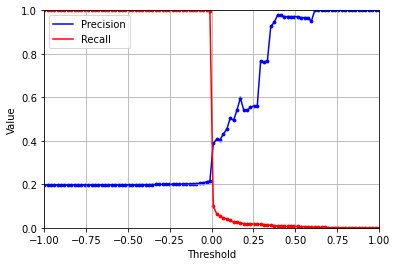

In [18]:
avg_type = 'macro'
precision_arr = np.load(occlusion_root_dir / f'precision_{avg_type}_avg_arr.npy')
recall_arr = np.load(occlusion_root_dir / f'recall_{avg_type}_avg_arr.npy')

f, ax = plt.subplots()
ax.scatter(thr_arr, precision_arr, color='b', s=8)
ax.plot(thr_arr, precision_arr, 'b', label='Precision')
ax.scatter(thr_arr, recall_arr, color='r', s=8)
ax.plot(thr_arr, recall_arr, 'r', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.grid()
ax.legend()
ax.set_xlim(thr_arr[[0, -1]])
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_xscale('log')
f.savefig(occlusion_root_dir / f'precision_recall_{avg_type}_avg.pdf')

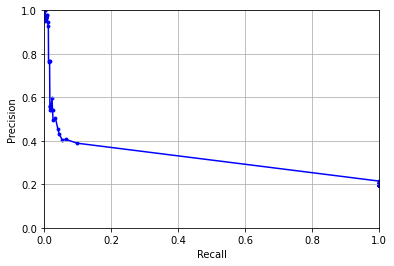

In [19]:
# plot PR curve
f, ax = plt.subplots()
ax.scatter(recall_arr, precision_arr, color='b', s=8)
ax.plot(recall_arr, precision_arr, 'b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(right=1)
f.savefig(occlusion_root_dir / f'pr_curve_{avg_type}_avg.pdf')

# Compute and plot precision and recall for no flags

In [20]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros(thr_arr.shape, dtype='float'), np.nan * np.zeros(thr_arr.shape, dtype='float')
for thr_i, thr in enumerate(thr_arr):

    # add no_flag column; set to one when all other flags have non-positive explanation scores
    idxs_allfps_inactive = (occlusion_array <= thr).all(axis=1)
    noflag_explanation = np.zeros((len(occlusion_array), 1), dtype='float')
    noflag_explanation[idxs_allfps_inactive] = 1

    precision_arr[thr_i] = precision_score(robo_noflag, noflag_explanation, zero_division=1)
    recall_arr[thr_i] = recall_score(robo_noflag, noflag_explanation, zero_division=1)

np.save(occlusion_root_dir / 'precision_arr_noflag.npy', precision_arr)
np.save(occlusion_root_dir / 'recall_arr_noflag.npy', recall_arr)

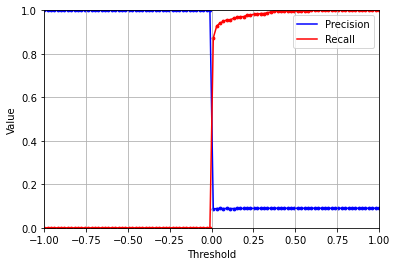

In [21]:
f, ax = plt.subplots()
ax.scatter(thr_arr, precision_arr, color='b', s=8)
ax.plot(thr_arr, precision_arr, 'b', label='Precision')
ax.scatter(thr_arr, recall_arr, color='r', s=8)
ax.plot(thr_arr, recall_arr, 'r', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.grid()
ax.legend()
ax.set_xlim(thr_arr[[0, -1]])
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_xscale('log')
# ax.set_yscale('log')
f.savefig(occlusion_root_dir / f'precision_recall_thr_noneflag.pdf')

In [22]:
# compute precision and recall for no flag for a set of thresholds and save it to a csv file
thr_arr = np.linspace(-1, 1, 21, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros(thr_arr.shape, dtype='float'), np.nan * np.zeros(thr_arr.shape, dtype='float')
for thr_i, thr in enumerate(thr_arr):

    # add no_flag column; set to one when all other flags have non-positive explanation scores
    idxs_allfps_inactive = (occlusion_array <= thr).all(axis=1)
    noflag_explanation = np.zeros((len(occlusion_array), 1), dtype='float')
    noflag_explanation[idxs_allfps_inactive] = 1

    precision_arr[thr_i] = precision_score(robo_noflag, noflag_explanation, zero_division=1)
    recall_arr[thr_i] = recall_score(robo_noflag, noflag_explanation, zero_division=1)

data_df = pd.DataFrame({'thr': thr_arr, 'precision': precision_arr, 'recall': recall_arr})
data_df.to_csv(occlusion_root_dir / 'precision_recall_noflag.csv', index=False)

# Plot histogram of scores for each flag

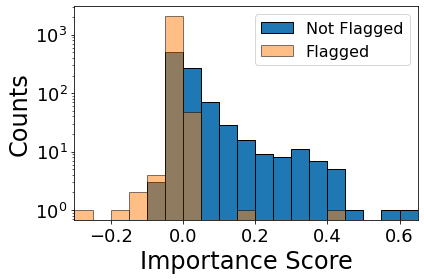

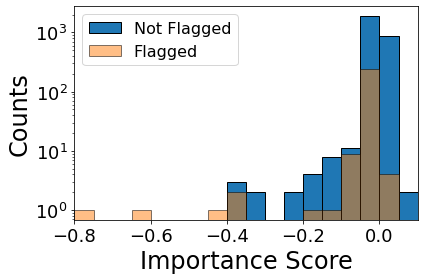

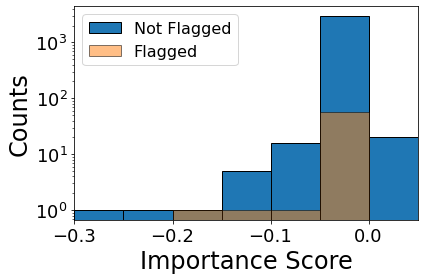

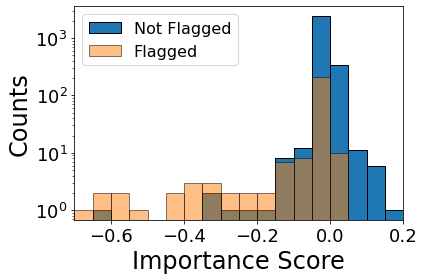

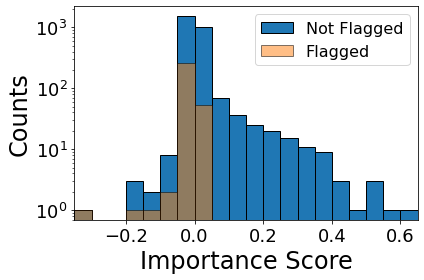

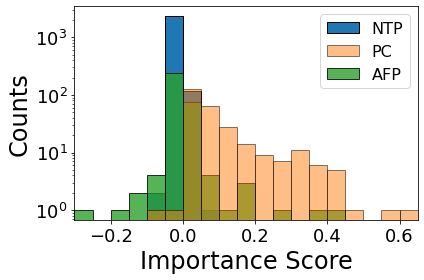

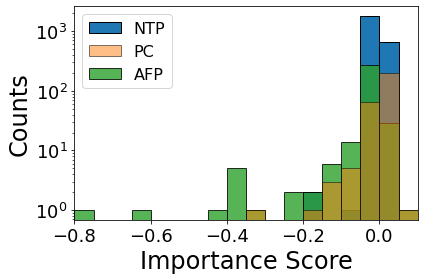

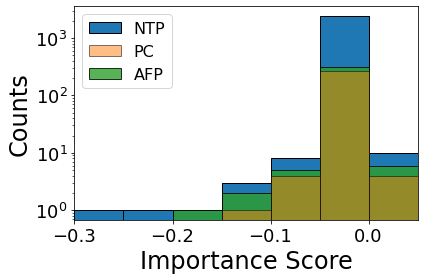

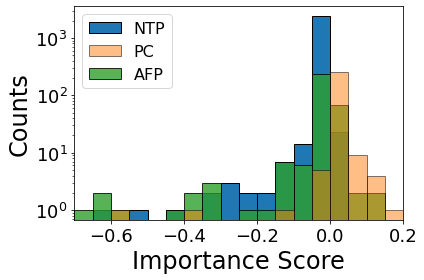

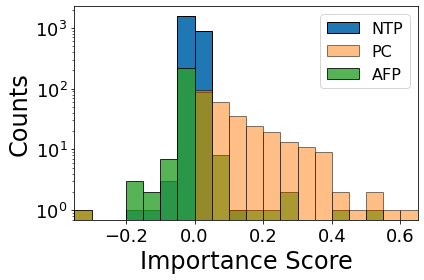

In [102]:
bins = np.arange(-1, 1, 0.05)
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']

for flag_i, flag in enumerate(flags):

    examples_pos = -1 * occlusion[:, flag_i][robo[:, flag_i] == 1]
    examples_neg = -1 * occlusion[:, flag_i][robo[:, flag_i] == 0]

    f, ax = plt.subplots()
    ax.hist(examples_neg, bins, edgecolor='k', zorder=0, label='Not Flagged')
    ax.hist(examples_pos, bins, edgecolor='k', zorder=1, label='Flagged', alpha=0.5)
    ax.set_xlabel('Importance Score', fontsize=24)
    ax.set_ylabel('Counts', fontsize=24)
    ax.legend(fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_yscale('log')
    # ax.grid()
    if flag == 'Centroid Flag':
        ax.set_xlim([-0.8, 0.1])
    elif flag == 'Odd Even Flag':
        ax.set_xlim([-0.3, 0.05])
    elif flag == 'Flux Flag':
        ax.set_xlim([-0.3, 0.65])
    elif flag == 'Secondary Flag':
        ax.set_xlim([-0.7, 0.2])
    elif flag == 'DV Flag':
        ax.set_xlim([-0.35, 0.65])
    else:
        ax.set_xlim([-1, 1])
    f.tight_layout()
    f.savefig(occlusion_root_dir / f'hist_scores_flaggedvsnonflagged_flag_{flag}_occlusion.pdf')

for flag_i, flag in enumerate(flags):

    examples_pos = -1 * occlusion[:, flag_i][test_csv['original_label'] == 'PC']
    examples_neg = -1 * occlusion[:, flag_i][test_csv['original_label'] == 'NTP']
    examples_afp = -1 * occlusion[:, flag_i][test_csv['original_label'] == 'AFP']

    f, ax = plt.subplots()
    ax.hist(examples_neg, bins, edgecolor='k', zorder=0, label='NTP')
    ax.hist(examples_pos, bins, edgecolor='k', zorder=2, label='PC', alpha=0.5)
    ax.hist(examples_afp, bins, edgecolor='k', zorder=1, label='AFP', alpha=0.8)
    ax.set_xlabel('Importance Score', fontsize=24)
    ax.set_ylabel('Counts', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=16)
    ax.set_yscale('log')
    # ax.grid()
    # ax.set_xlim(bins[[0, -1]])
    if flag == 'Centroid Flag':
        ax.set_xlim([-0.8, 0.1])
    elif flag == 'Odd Even Flag':
        ax.set_xlim([-0.3, 0.05])
    elif flag == 'Flux Flag':
        ax.set_xlim([-0.3, 0.65])
    elif flag == 'Secondary Flag':
        ax.set_xlim([-0.7, 0.2])
    elif flag == 'DV Flag':
        ax.set_xlim([-0.35, 0.65])
    else:
        ax.set_xlim([-1, 1])
    f.tight_layout()
    f.savefig(occlusion_root_dir / f'hist_scores_labels_flag_{flag}_pcvsfp_occlusion.pdf')


# Precision and recall threshold per flag

In [24]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros((len(flags), len(thr_arr)), dtype='float'), np.nan * np.zeros((len(flags), len(thr_arr)), dtype='float')
for thr_i, thr in enumerate(thr_arr):

        branch_explanations_thr = threshold(occlusion, thr)

        # # add no_flag column; set to one when all other flags have non-positive explanation scores
        # branch_explanations_thr[(branch_explanations_thr[:, :-1] == 0).all(axis=1), -1] = 1

        for flag_i in range(len(flags)):
            precision_arr[flag_i, thr_i] = precision_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)
            recall_arr[flag_i, thr_i] = recall_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)

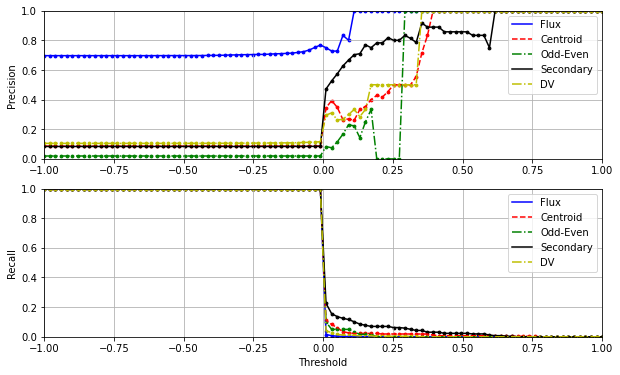

In [25]:
flag_plot_params = {
    'Flux': {'name': 'Flux', 'color': 'b', 'linestyle': '-'},
    'Centroid': {'name': 'Centroid', 'color': 'r', 'linestyle': '--'},
    'Odd-Even': {'name': 'Odd-Even', 'color': 'g', 'linestyle': '-.'},
    'Secondary': {'name': 'Secondary', 'color': 'k', 'linestyle': '-'},
    'DV': {'name': 'DV', 'color': 'y', 'linestyle': '-.'},
    # 'No Flag': {'name': 'No Flag', 'color': 'm', 'linestyle': '-.'},
}
f, ax = plt.subplots(2, 1, figsize=(10, 6))
for flag_i, flag in enumerate(flag_plot_params):
    ax[0].scatter(thr_arr, precision_arr[flag_i, :], color=flag_plot_params[flag]['color'], s=8)
    ax[0].plot(thr_arr, precision_arr[flag_i, :], label=flag_plot_params[flag]['name'], color=flag_plot_params[flag]['color'], linestyle=flag_plot_params[flag]['linestyle'])

    ax[1].scatter(thr_arr, recall_arr[flag_i, :], color=flag_plot_params[flag]['color'], s=8)
    ax[1].plot(thr_arr, recall_arr[flag_i, :], label=flag_plot_params[flag]['name'], color=flag_plot_params[flag]['color'], linestyle=flag_plot_params[flag]['linestyle'])

ax[0].set_ylabel('Precision')
ax[0].set_xlim(thr_arr[[0, -1]])
ax[0].set_ylim([0, 1])
ax[0].grid(True)
ax[0].legend()

ax[1].set_ylabel('Recall')
ax[1].set_xlim(thr_arr[[0, -1]])
ax[1].set_ylim([0, 1])
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlabel('Threshold')

f.savefig(occlusion_root_dir / 'precision_recall_thr_per_flag.pdf')